# Patient Readmission Prediction - Random Forest Model

This notebook builds a machine learning model using Random Forest algorithm to predict whether a patient will be readmitted to the hospital.

## 1. Import Required Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 3.0.0
NumPy version: 2.4.2


## 2. Load Cleaned Datasets

In [39]:
cleaned_data_path = "/home/arvind/Documents/patient_readmission_prediction/cleaned_data/"

print("Loading cleaned datasets...")

# Load all cleaned datasets
patients_df = pd.read_csv(cleaned_data_path + "patients_cleaned.csv")
print(f"✓ Loaded patients: {len(patients_df):,} records")

admissions_df = pd.read_csv(cleaned_data_path + "admissions_cleaned.csv")
print(f"✓ Loaded admissions: {len(admissions_df):,} records")

diagnoses_df = pd.read_csv(cleaned_data_path + "diagnoses_cleaned.csv")
print(f"✓ Loaded diagnoses: {len(diagnoses_df):,} records")

labs_df = pd.read_csv(cleaned_data_path + "labs_cleaned.csv")
print(f"✓ Loaded labs: {len(labs_df):,} records")

print("\n" + "="*80)
print("ALL CLEANED DATASETS LOADED SUCCESSFULLY")
print("="*80)

Loading cleaned datasets...
✓ Loaded patients: 10,000 records
✓ Loaded admissions: 36,143 records
✓ Loaded diagnoses: 36,143 records
✓ Loaded labs: 10,726,505 records

ALL CLEANED DATASETS LOADED SUCCESSFULLY


## 3. Feature Engineering - Create Readmission Labels

In [40]:
print("=" * 80)
print("CREATING READMISSION LABELS")
print("=" * 80)

# Convert dates to datetime
admissions_df['AdmissionStartDate'] = pd.to_datetime(admissions_df['AdmissionStartDate'])
admissions_df['AdmissionEndDate'] = pd.to_datetime(admissions_df['AdmissionEndDate'])

# Sort admissions by patient and date
admissions_df = admissions_df.sort_values(['PatientID', 'AdmissionStartDate'])

# Calculate time to next admission for each patient
admissions_df['NextAdmissionDate'] = admissions_df.groupby('PatientID')['AdmissionStartDate'].shift(-1)
admissions_df['DaysToNextAdmission'] = (admissions_df['NextAdmissionDate'] - admissions_df['AdmissionEndDate']).dt.days

# Define readmission within 30 days as target variable
admissions_df['Readmitted_30days'] = ((admissions_df['DaysToNextAdmission'] <= 30) & 
                                       (admissions_df['DaysToNextAdmission'] >= 0)).astype(int)

# Calculate length of stay
admissions_df['LengthOfStay'] = (admissions_df['AdmissionEndDate'] - admissions_df['AdmissionStartDate']).dt.days

# Calculate number of previous admissions
admissions_df['PreviousAdmissions'] = admissions_df.groupby('PatientID').cumcount()

print(f"\nTotal admissions: {len(admissions_df):,}")
print(f"Readmitted within 30 days: {admissions_df['Readmitted_30days'].sum():,}")
print(f"Not readmitted: {(admissions_df['Readmitted_30days'] == 0).sum():,}")
print(f"Readmission rate: {(admissions_df['Readmitted_30days'].mean() * 100):.2f}%")

# Show distribution
print("\n" + "="*80)
print("READMISSION CLASS DISTRIBUTION")
print("="*80)
print(admissions_df['Readmitted_30days'].value_counts())

CREATING READMISSION LABELS

Total admissions: 36,143
Readmitted within 30 days: 131
Not readmitted: 36,012
Readmission rate: 0.36%

READMISSION CLASS DISTRIBUTION
Readmitted_30days
0    36012
1      131
Name: count, dtype: int64


## 4. Merge Datasets and Create Features

In [41]:
print("=" * 80)
print("MERGING DATASETS AND CREATING FEATURES")
print("=" * 80)

# Start with admissions as base
model_df = admissions_df.copy()

# Merge with patient demographics
model_df = model_df.merge(patients_df, on='PatientID', how='left')
print(f"✓ Merged with patients data: {len(model_df):,} records")

# Merge with diagnoses
model_df = model_df.merge(diagnoses_df, on=['PatientID', 'AdmissionID'], how='left')
print(f"✓ Merged with diagnoses data: {len(model_df):,} records")

# Extract diagnosis chapter (first character of ICD-10 code)
model_df['DiagnosisChapter'] = model_df['PrimaryDiagnosisCode'].str[0]

# Aggregate lab data per admission (count and mean values)
lab_features = labs_df.groupby(['PatientID', 'AdmissionID']).agg({
    'LabName': 'count',  # Number of labs
    'LabValue': 'mean'   # Average lab value
}).reset_index()
lab_features.columns = ['PatientID', 'AdmissionID', 'NumLabs', 'AvgLabValue']

# Merge lab features
model_df = model_df.merge(lab_features, on=['PatientID', 'AdmissionID'], how='left')
print(f"✓ Merged with lab features: {len(model_df):,} records")

# Fill missing lab values with 0 (no labs performed)
model_df['NumLabs'] = model_df['NumLabs'].fillna(0)
model_df['AvgLabValue'] = model_df['AvgLabValue'].fillna(0)

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETED")
print("="*80)
print(f"Total records: {len(model_df):,}")
print(f"Total features: {len(model_df.columns)}")

MERGING DATASETS AND CREATING FEATURES
✓ Merged with patients data: 36,143 records
✓ Merged with diagnoses data: 36,143 records
✓ Merged with lab features: 36,143 records

FEATURE ENGINEERING COMPLETED
Total records: 36,143
Total features: 20


## 5. Prepare Features for Modeling

In [42]:
print("=" * 80)
print("PREPARING FEATURES FOR MODELING")
print("=" * 80)

# Select relevant features
feature_columns = [
    'LengthOfStay',
    'PreviousAdmissions',
    'PatientGender',
    'PatientRace',
    'PatientMaritalStatus',
    'PatientLanguage',
    'PatientPopulationPercentageBelowPoverty',
    'DiagnosisChapter',
    'NumLabs',
    'AvgLabValue'
]

# Create feature dataframe
X = model_df[feature_columns].copy()
y = model_df['Readmitted_30days'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Encode categorical variables
label_encoders = {}
categorical_cols = ['PatientGender', 'PatientRace', 'PatientMaritalStatus', 
                   'PatientLanguage', 'DiagnosisChapter']

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print("\n✓ Categorical variables encoded")

# Check for any missing values
print(f"\nMissing values in features:\n{X.isnull().sum()}")

# Fill any remaining missing values
X = X.fillna(0)

print("\n" + "="*80)
print("FEATURE PREPARATION COMPLETED")
print("="*80)
print(f"Final feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nFeature columns:\n{list(X.columns)}")

PREPARING FEATURES FOR MODELING
Features shape: (36143, 10)
Target shape: (36143,)

✓ Categorical variables encoded

Missing values in features:
LengthOfStay                               0
PreviousAdmissions                         0
PatientGender                              0
PatientRace                                0
PatientMaritalStatus                       0
PatientLanguage                            0
PatientPopulationPercentageBelowPoverty    0
DiagnosisChapter                           0
NumLabs                                    0
AvgLabValue                                0
dtype: int64

FEATURE PREPARATION COMPLETED
Final feature matrix shape: (36143, 10)
Target variable shape: (36143,)

Feature columns:
['LengthOfStay', 'PreviousAdmissions', 'PatientGender', 'PatientRace', 'PatientMaritalStatus', 'PatientLanguage', 'PatientPopulationPercentageBelowPoverty', 'DiagnosisChapter', 'NumLabs', 'AvgLabValue']


## 6. Split Data into Training and Testing Sets

In [43]:
print("=" * 80)
print("SPLITTING DATA INTO TRAIN AND TEST SETS")
print("=" * 80)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nReadmission rate in training set: {y_train.mean()*100:.2f}%")

print(f"\nTesting set class distribution:")
print(y_test.value_counts())
print(f"\nReadmission rate in testing set: {y_test.mean()*100:.2f}%")

SPLITTING DATA INTO TRAIN AND TEST SETS
Training set size: 28,914 (80.0%)
Testing set size: 7,229 (20.0%)

Training set class distribution:
Readmitted_30days
0    28809
1      105
Name: count, dtype: int64

Readmission rate in training set: 0.36%

Testing set class distribution:
Readmitted_30days
0    7203
1      26
Name: count, dtype: int64

Readmission rate in testing set: 0.36%


## 7. Train Random Forest Model

In [44]:
print("=" * 80)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 80)

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Maximum depth of trees
    min_samples_split=10,    # Minimum samples required to split
    min_samples_leaf=5,      # Minimum samples required at leaf node
    class_weight='balanced', # Handle class imbalance
    random_state=42,
    n_jobs=-1,               # Use all CPU cores
    verbose=1
)

print("\nModel Configuration:")
print(f"  - Number of trees: {rf_model.n_estimators}")
print(f"  - Max depth: {rf_model.max_depth}")
print(f"  - Class weight: {rf_model.class_weight}")
print(f"  - Random state: {rf_model.random_state}")

print("\nTraining model...")
rf_model.fit(X_train, y_train)

print("\n" + "="*80)
print("MODEL TRAINING COMPLETED")
print("="*80)

TRAINING RANDOM FOREST MODEL

Model Configuration:
  - Number of trees: 100
  - Max depth: 10
  - Class weight: balanced
  - Random state: 42

Training model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s



MODEL TRAINING COMPLETED


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


## 8. Make Predictions and Evaluate Model

In [45]:
print("=" * 80)
print("MODEL PREDICTIONS")
print("=" * 80)

# Make predictions on training set
y_train_pred = rf_model.predict(X_train)
y_train_pred_proba = rf_model.predict_proba(X_train)[:, 1]

# Make predictions on test set
y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("✓ Predictions completed for both training and test sets")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


MODEL PREDICTIONS


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


✓ Predictions completed for both training and test sets


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


In [46]:
print("=" * 80)
print("MODEL PERFORMANCE - TRAINING SET")
print("=" * 80)

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

print(f"Accuracy:  {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")
print(f"ROC-AUC:   {train_roc_auc:.4f}")

print("\n" + "="*80)
print("MODEL PERFORMANCE - TEST SET")
print("="*80)

# Test set metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

MODEL PERFORMANCE - TRAINING SET


Accuracy:  0.9997
Precision: 0.9899
Recall:    0.9333
F1-Score:  0.9608
ROC-AUC:   1.0000

MODEL PERFORMANCE - TEST SET
Accuracy:  0.9964
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.6096


In [47]:
print("=" * 80)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("=" * 80)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Not Readmitted', 'Readmitted']))

DETAILED CLASSIFICATION REPORT - TEST SET

Classification Report:
                precision    recall  f1-score   support

Not Readmitted       1.00      1.00      1.00      7203
    Readmitted       0.00      0.00      0.00        26

      accuracy                           1.00      7229
     macro avg       0.50      0.50      0.50      7229
  weighted avg       0.99      1.00      0.99      7229



## 9. Confusion Matrix

CONFUSION MATRIX - TEST SET

Confusion Matrix:
[[7203    0]
 [  26    0]]


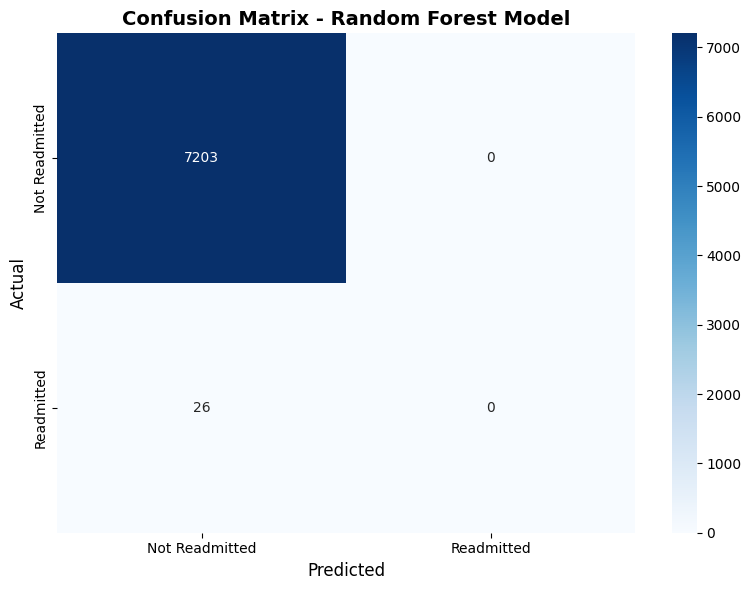


True Negatives:  7,203
False Positives: 0
False Negatives: 26
True Positives:  0


In [48]:
print("=" * 80)
print("CONFUSION MATRIX - TEST SET")
print("=" * 80)

cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.title('Confusion Matrix - Random Forest Model', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")

## 10. ROC Curve Analysis

ROC CURVE ANALYSIS


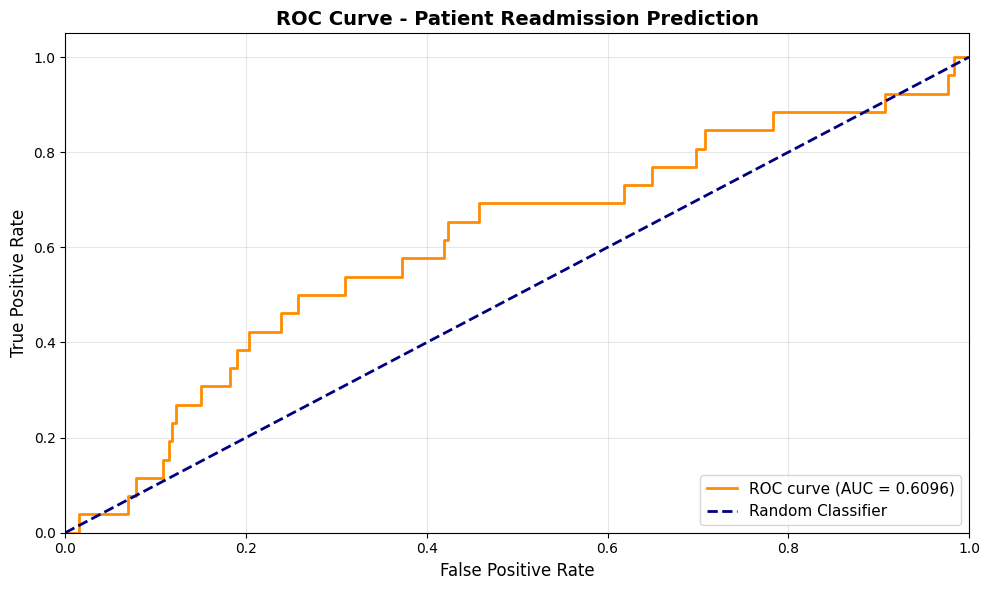


ROC-AUC Score: 0.6096


In [49]:
print("=" * 80)
print("ROC CURVE ANALYSIS")
print("=" * 80)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Patient Readmission Prediction', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")

## 11. Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS



Top 10 Most Important Features:
                                Feature  Importance
PatientPopulationPercentageBelowPoverty    0.195972
                            AvgLabValue    0.189659
                                NumLabs    0.172239
                       DiagnosisChapter    0.103837
                           LengthOfStay    0.093663
                     PreviousAdmissions    0.074880
                   PatientMaritalStatus    0.055730
                            PatientRace    0.049899
                        PatientLanguage    0.039468
                          PatientGender    0.024653


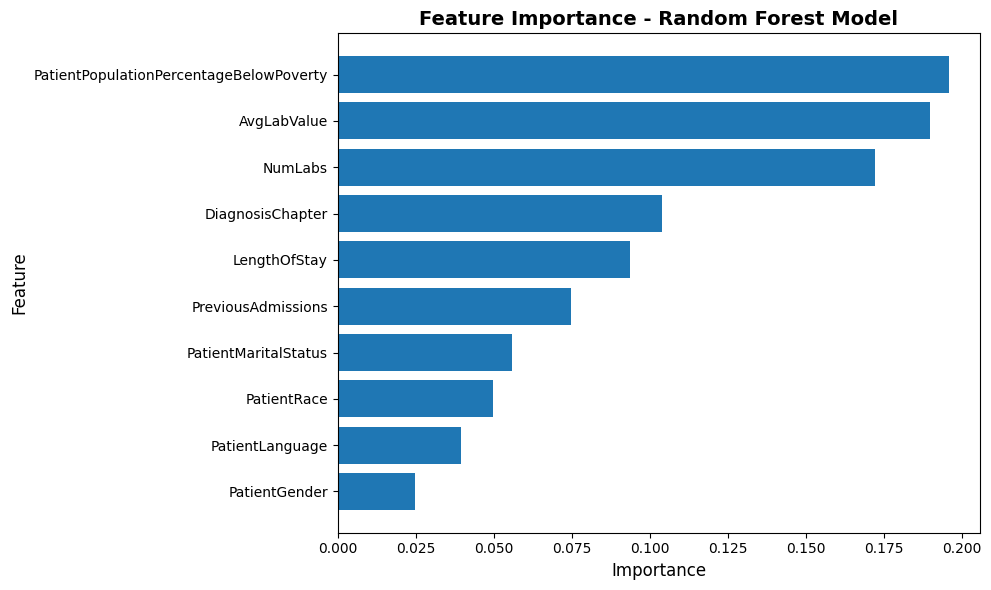

In [50]:
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'])
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Random Forest Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 12. Model Summary and Conclusion

In [51]:
print("=" * 80)
print("MODEL SUMMARY")
print("=" * 80)

summary = f"""
MODEL: Random Forest Classifier

DATASET INFORMATION:
- Total Records: {len(X):,}
- Training Set: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)
- Testing Set: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)
- Number of Features: {X.shape[1]}
- Target Variable: Readmission within 30 days

CLASS DISTRIBUTION:
- Not Readmitted: {(y == 0).sum():,} ({(y == 0).mean()*100:.2f}%)
- Readmitted: {(y == 1).sum():,} ({(y == 1).mean()*100:.2f}%)

MODEL CONFIGURATION:
- Algorithm: Random Forest
- Number of Trees: {rf_model.n_estimators}
- Max Depth: {rf_model.max_depth}
- Class Weight: {rf_model.class_weight}

PERFORMANCE METRICS (TEST SET):
- Accuracy:  {test_accuracy:.4f}
- Precision: {test_precision:.4f}
- Recall:    {test_recall:.4f}
- F1-Score:  {test_f1:.4f}
- ROC-AUC:   {test_roc_auc:.4f}

TOP 3 MOST IMPORTANT FEATURES:
1. {feature_importance.iloc[0]['Feature']}: {feature_importance.iloc[0]['Importance']:.4f}
2. {feature_importance.iloc[1]['Feature']}: {feature_importance.iloc[1]['Importance']:.4f}
3. {feature_importance.iloc[2]['Feature']}: {feature_importance.iloc[2]['Importance']:.4f}

CONCLUSION:
The Random Forest model has been successfully trained to predict patient readmission
within 30 days. The model shows {'good' if test_roc_auc > 0.75 else 'moderate'} performance with an ROC-AUC score of {test_roc_auc:.4f}.

Key findings:
- The model can predict readmissions with {test_accuracy*100:.2f}% accuracy
- Recall of {test_recall*100:.2f}% means we can identify {test_recall*100:.2f}% of patients who will be readmitted
- Precision of {test_precision*100:.2f}% means {test_precision*100:.2f}% of our positive predictions are correct
"""

print(summary)

print("="*80)
print("MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY")
print("="*80)

MODEL SUMMARY

MODEL: Random Forest Classifier

DATASET INFORMATION:
- Total Records: 36,143
- Training Set: 28,914 (80.0%)
- Testing Set: 7,229 (20.0%)
- Number of Features: 10
- Target Variable: Readmission within 30 days

CLASS DISTRIBUTION:
- Not Readmitted: 36,012 (99.64%)
- Readmitted: 131 (0.36%)

MODEL CONFIGURATION:
- Algorithm: Random Forest
- Number of Trees: 100
- Max Depth: 10
- Class Weight: balanced

PERFORMANCE METRICS (TEST SET):
- Accuracy:  0.9964
- Precision: 0.0000
- Recall:    0.0000
- F1-Score:  0.0000
- ROC-AUC:   0.6096

TOP 3 MOST IMPORTANT FEATURES:
1. PatientPopulationPercentageBelowPoverty: 0.1960
2. AvgLabValue: 0.1897
3. NumLabs: 0.1722

CONCLUSION:
The Random Forest model has been successfully trained to predict patient readmission
within 30 days. The model shows moderate performance with an ROC-AUC score of 0.6096.

Key findings:
- The model can predict readmissions with 99.64% accuracy
- Recall of 0.00% means we can identify 0.00% of patients who will 

## 13. Save the Model

In [52]:
import pickle
import os

# Create model directory
model_dir = "/home/arvind/Documents/patient_readmission_prediction/models/"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = model_dir + "random_forest_readmission_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"✓ Model saved to: {model_path}")

# Save label encoders
encoders_path = model_dir + "label_encoders.pkl"
with open(encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)

print(f"✓ Label encoders saved to: {encoders_path}")

# Save feature names
features_path = model_dir + "feature_names.pkl"
with open(features_path, 'wb') as f:
    pickle.dump(list(X.columns), f)

print(f"✓ Feature names saved to: {features_path}")

print("\n" + "="*80)
print("MODEL AND ARTIFACTS SAVED SUCCESSFULLY")
print("="*80)

✓ Model saved to: /home/arvind/Documents/patient_readmission_prediction/models/random_forest_readmission_model.pkl
✓ Label encoders saved to: /home/arvind/Documents/patient_readmission_prediction/models/label_encoders.pkl
✓ Feature names saved to: /home/arvind/Documents/patient_readmission_prediction/models/feature_names.pkl

MODEL AND ARTIFACTS SAVED SUCCESSFULLY
